# Default of payments

Tasks:
- Propose a ML classifier exploiting a random forest, and a random forest AFTER exploiting a Lasso regression to reduce the number of features; compare the two classifiers. Always choose
the optimal hyperparameters.
- Use Interpretability tools to explain the predictions.

## Table of content
1. [Libraries and Data Load](#libraries-and-data-load)
2. [Data Cleaning](#data-cleaning)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Random Forest with All Features](#random-forest-with-all-features)
5. [Feature Selection Using Lasso](#feature-selection-using-lasso)
6. [Random Forest with Lasso Selected Features](#random-forest-with-lasso-selected-features)
7. [Model Interpretability](#model-interpretability)



---

## Libraries and Data Load

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

import shap

In [74]:
# Load the data
file_path = './Dataset3.csv'
data = pd.read_csv(file_path, delimiter=';')

In [75]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [82]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


---

## Data Cleaning

Check consistency in categorical variables

In [76]:
data['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [77]:
# Correct inconsistent values in the MARRIAGE variable
data['MARRIAGE'] = data['MARRIAGE'].replace(0, 3)  # Assuming 0 is unknown, treat it as others
unique_marriage = data['MARRIAGE'].unique()
unique_marriage

array([1, 2, 3])

In [78]:
data['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [79]:
# Correct inconsistent values in the EDUCATION variable
data['EDUCATION'] = data['EDUCATION'].replace([0, 5, 6], 4)  # Group 0, 5, and 6 into others
unique_education = data['EDUCATION'].unique()
unique_education

array([2, 1, 3, 4])

In [80]:
data['SEX'].unique()


array([2, 1])

---

## Exploratory Data Analysis

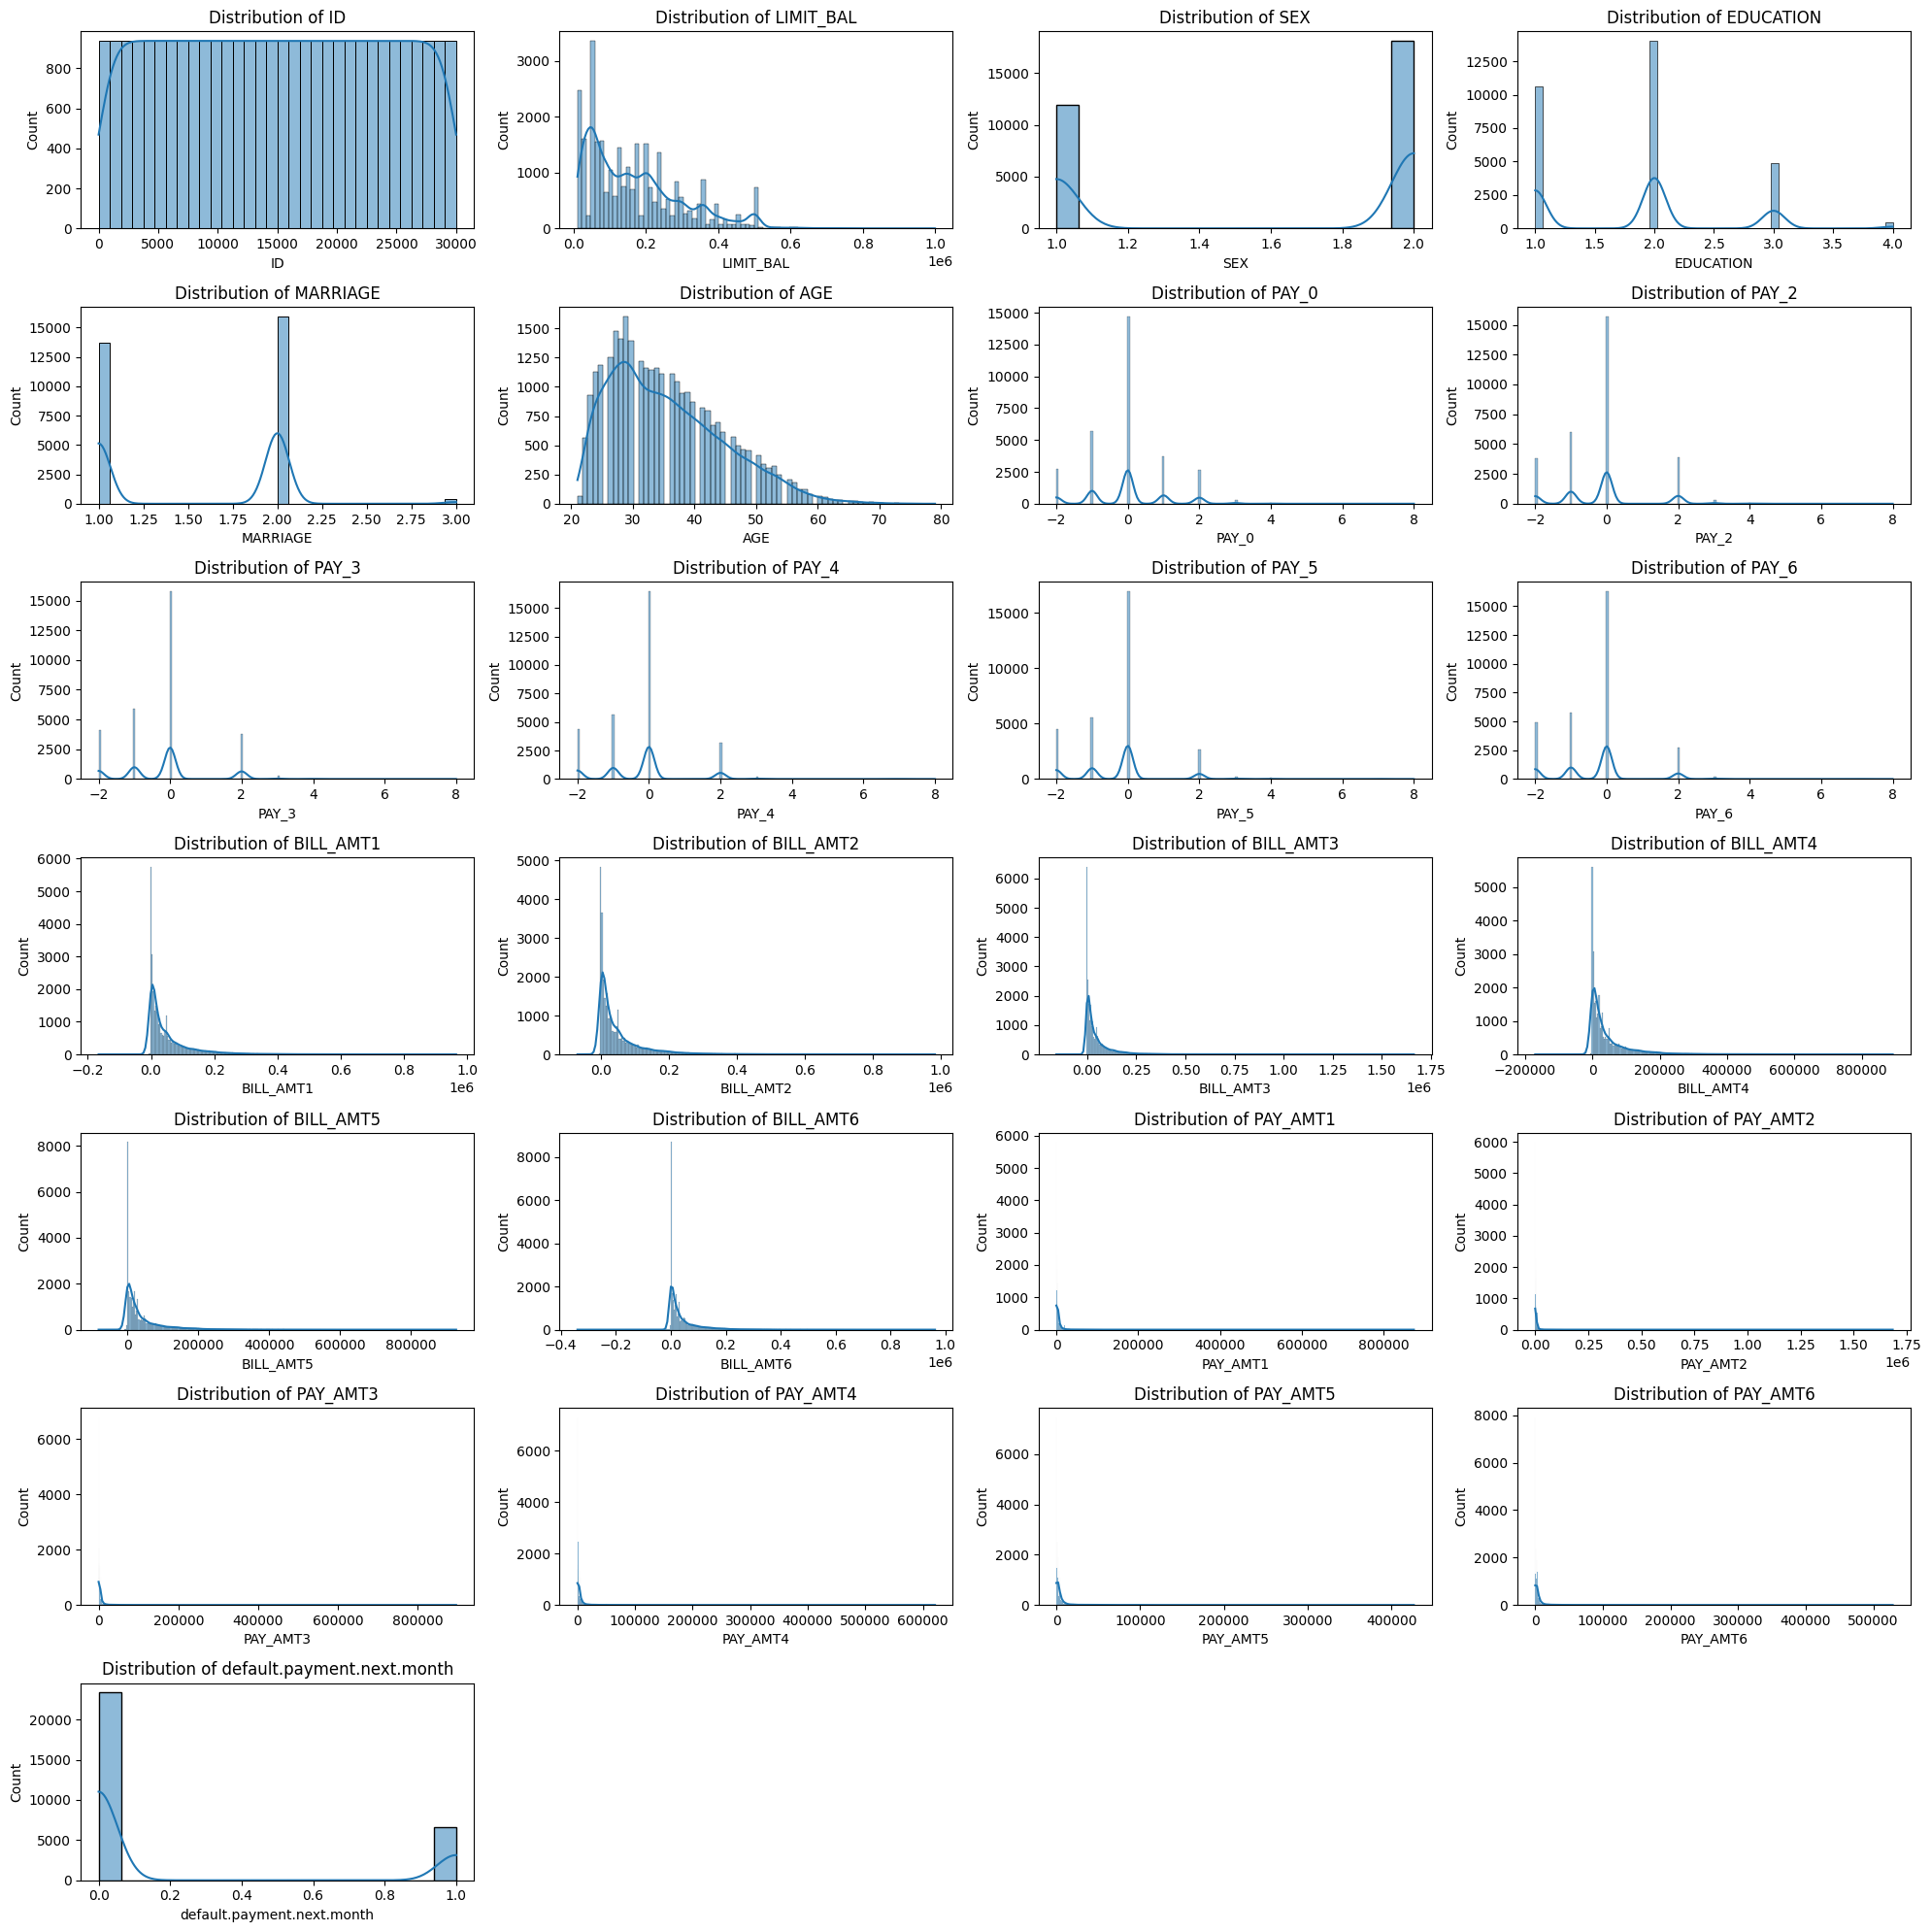

In [83]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(7, 4, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

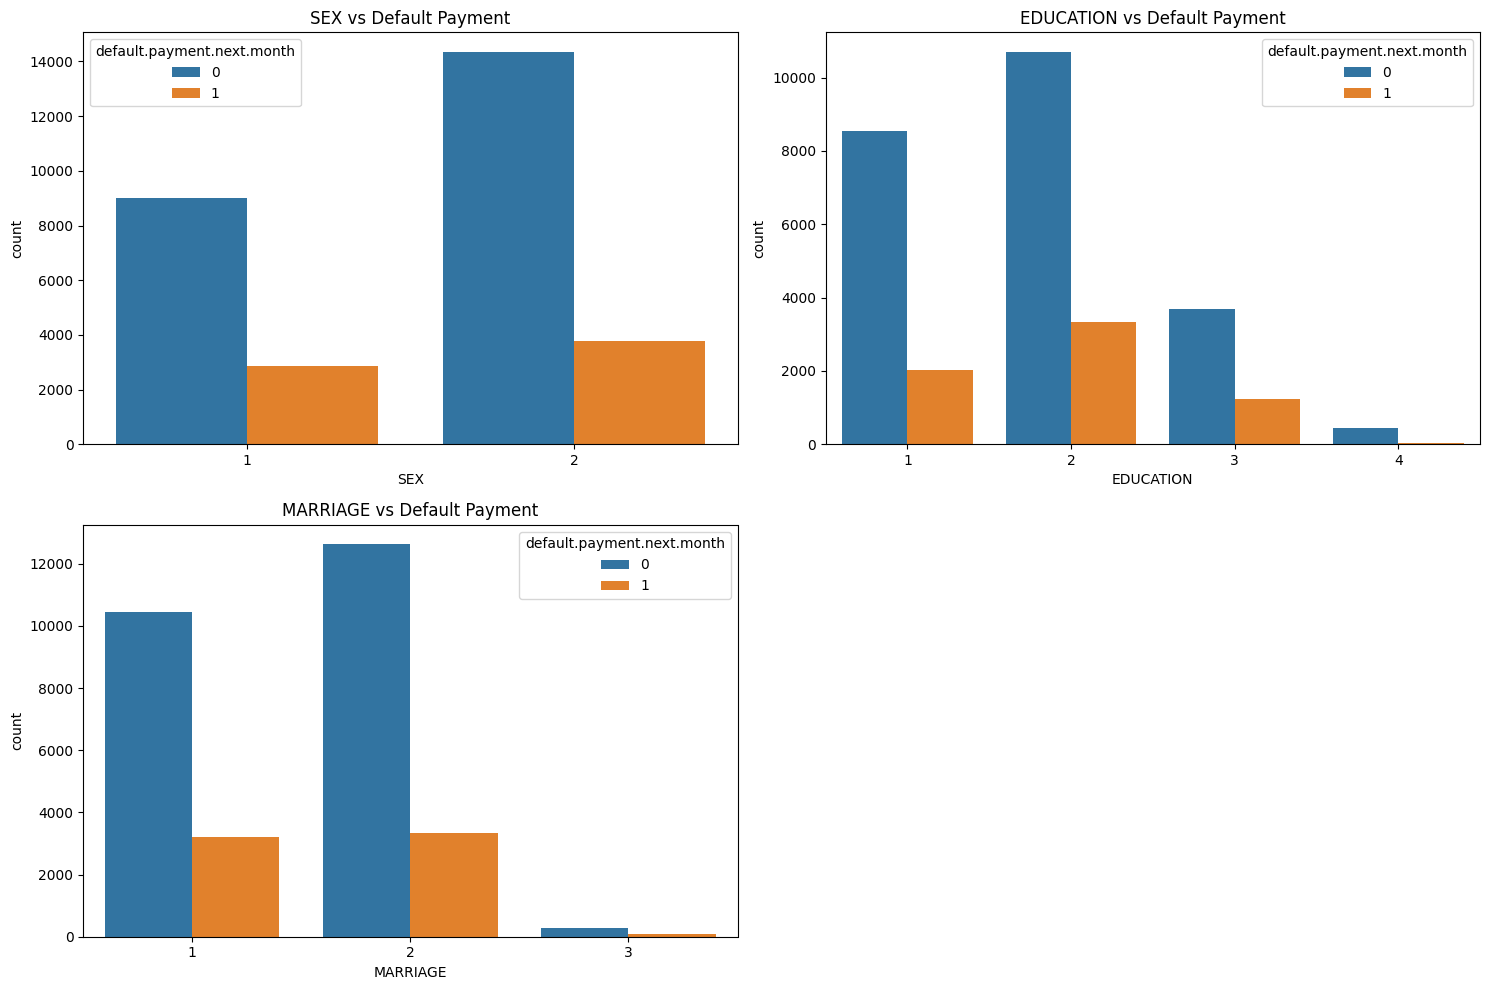

In [85]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=data[col], hue=data['default.payment.next.month'])
    plt.title(f'{col} vs Default Payment')
plt.tight_layout()
plt.show()

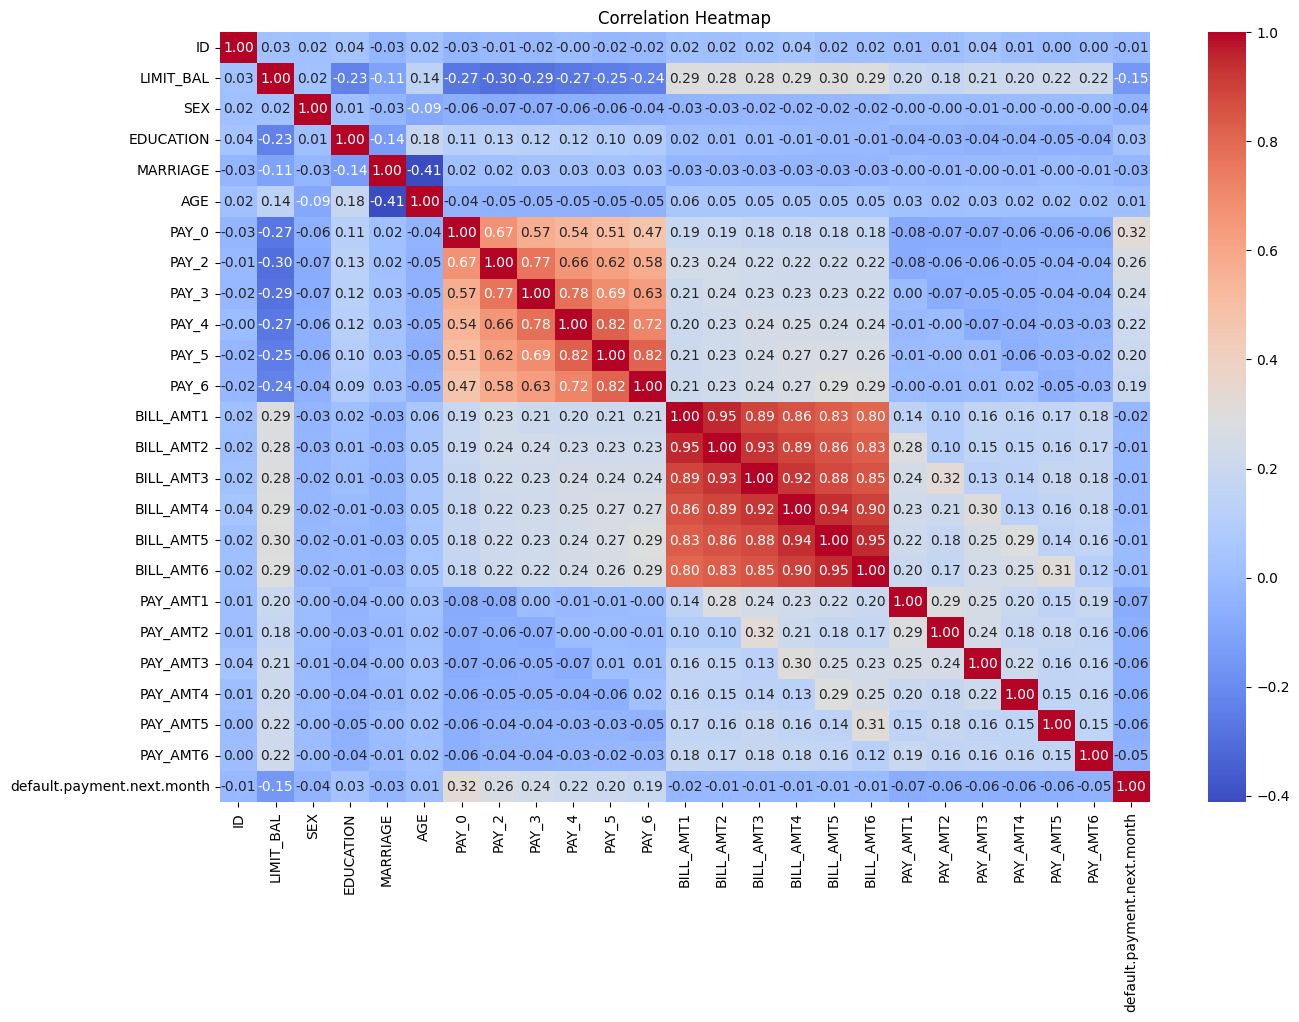

In [86]:
plt.figure(figsize=(15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

---

## Random Forest with All Features

In [87]:
# Separate features and target variable
X = data.drop(columns=['ID', 'default.payment.next.month'])
y = data['default.payment.next.month']

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

### GridSearchCV to Fine-Tune Hyperparameters

In [89]:
parameters = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [90]:
random_forest = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=random_forest, param_grid=parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.7s
[CV] END m

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             verbose=2)

In [91]:
random_forest_all_features = grid_search.best_estimator_

In [92]:
y_pred = random_forest_all_features.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7060
           1       0.67      0.36      0.47      1940

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.81      0.82      0.80      9000



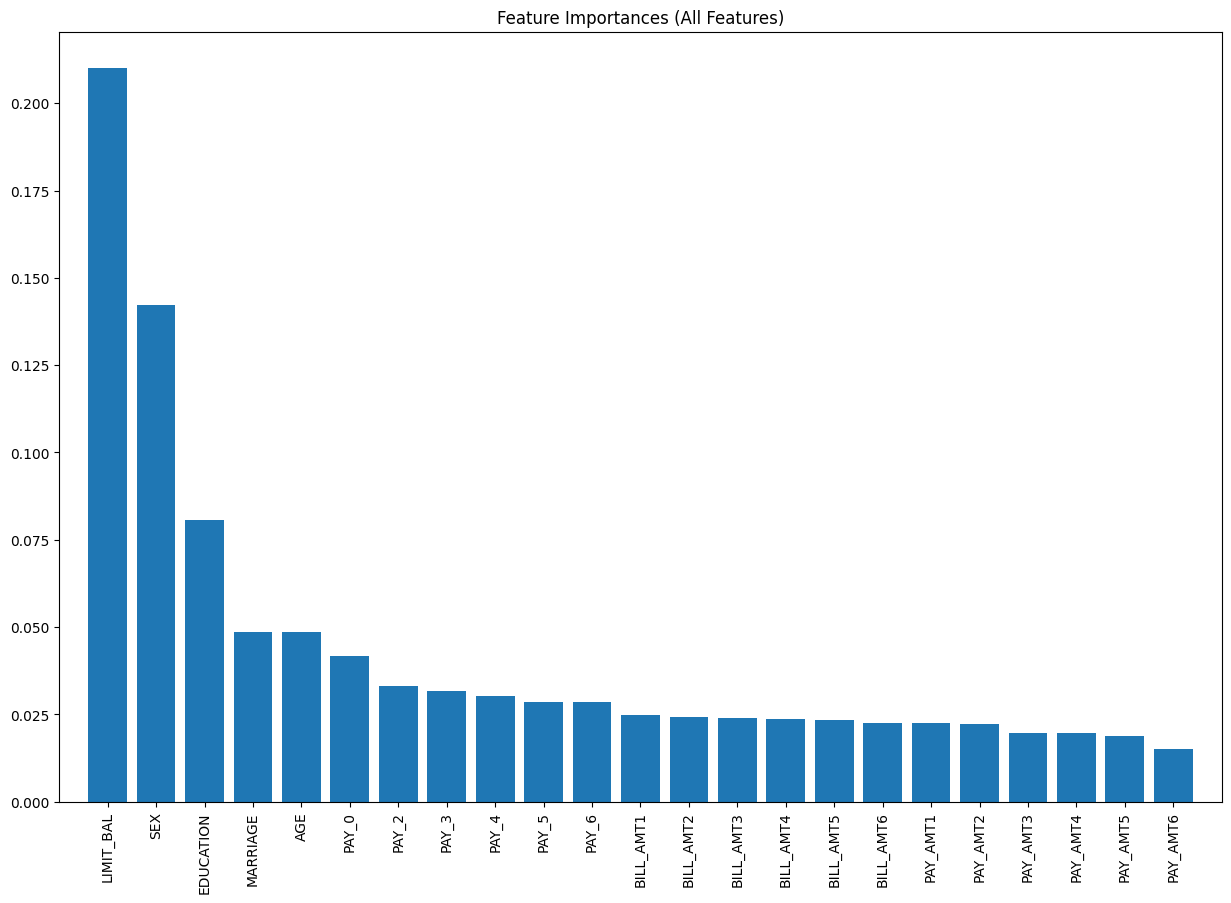

Feature ranking (all features):
1. Feature LIMIT_BAL (0.2099447096757072)
2. Feature SEX (0.14225787492656972)
3. Feature EDUCATION (0.08079296714575396)
4. Feature MARRIAGE (0.04850012823208308)
5. Feature AGE (0.0484779686904177)
6. Feature PAY_0 (0.04180369179892653)
7. Feature PAY_2 (0.033055538538673164)
8. Feature PAY_3 (0.031654616111641345)
9. Feature PAY_4 (0.03018221228080535)
10. Feature PAY_5 (0.028689785512174115)
11. Feature PAY_6 (0.028475445487194065)
12. Feature BILL_AMT1 (0.02473383378010612)
13. Feature BILL_AMT2 (0.02424903937637317)
14. Feature BILL_AMT3 (0.02404943108964065)
15. Feature BILL_AMT4 (0.023762114124705257)
16. Feature BILL_AMT5 (0.023357908324401332)
17. Feature BILL_AMT6 (0.022507170664265982)
18. Feature PAY_AMT1 (0.02244491383061355)
19. Feature PAY_AMT2 (0.022299391859273033)
20. Feature PAY_AMT3 (0.01982181927631675)
21. Feature PAY_AMT4 (0.019598802605800613)
22. Feature PAY_AMT5 (0.018873334932399854)
23. Feature PAY_AMT6 (0.015150168886698765)

In [125]:
# Feature importance for the model with all features
importances_all = random_forest_all_features.feature_importances_
indices_all = np.argsort(importances_all)[::-1]
feature_names_all = np.array(X.columns)

# Adjust indices
indices_all = indices_all[:len(feature_names_all)]

# Ensure the indices and feature names arrays are the same length
sorted_importances_all = importances_all[indices_all[:len(feature_names_all)]]
sorted_feature_names_all = feature_names_all[:len(indices_all)]

plt.figure(figsize=(15, 10))
plt.title("Feature Importances (All Features)")
plt.bar(range(len(sorted_importances_all)), sorted_importances_all, align="center")
plt.xticks(range(len(sorted_importances_all)), sorted_feature_names_all, rotation=90)
plt.xlim([-1, len(sorted_importances_all)])
plt.show()

# Print the feature ranking
print("Feature ranking (all features):")
for f in range(len(sorted_feature_names_all)):
    print(f"{f + 1}. Feature {sorted_feature_names_all[f]} ({sorted_importances_all[f]})")

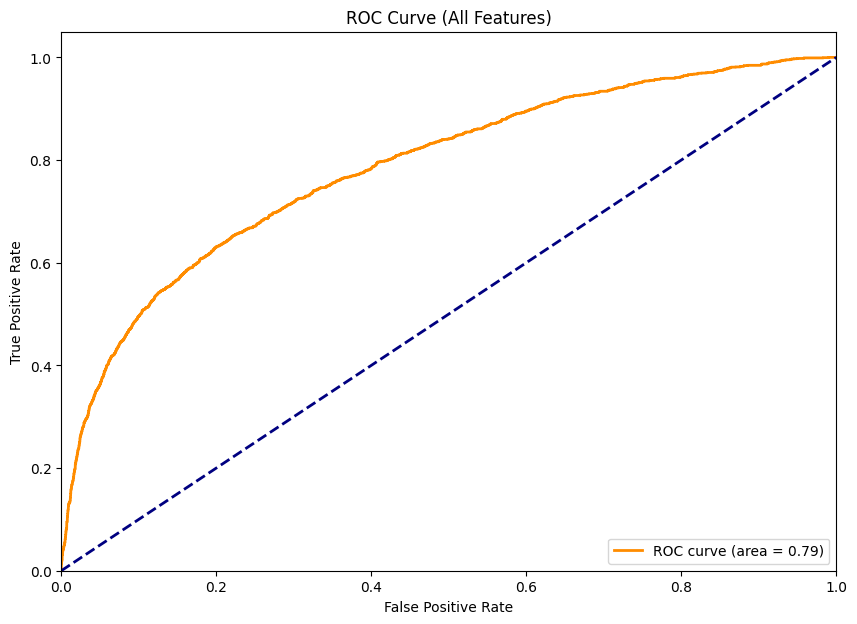

In [128]:
# ROC curve
fpr_all, tpr_all, _ = roc_curve(y_test, random_forest_all_features.predict_proba(X_test)[:, 1])
roc_auc_all = auc(fpr_all, tpr_all)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_all:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (All Features)')
plt.legend(loc="lower right")
plt.show()

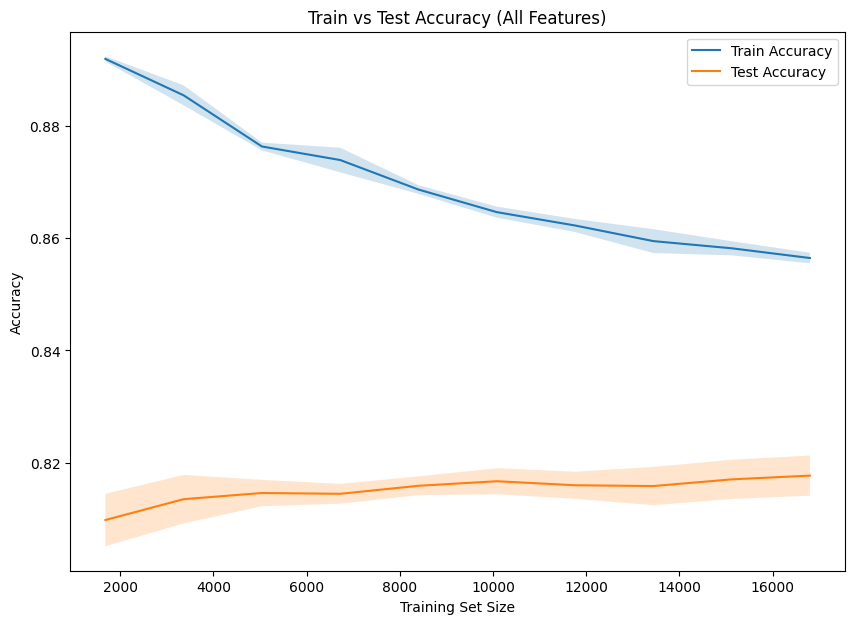

In [132]:
# Train vs Test Accuracy for Random Forest with All Features
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(random_forest_all_features, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Train Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Test Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy (All Features)')
plt.legend()
plt.show()

---

## Feature Selection Using Lasso

In [95]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [96]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.21187,-1.068797,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.21187,0.849131,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.21187,0.849131,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.21187,-1.068797,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.21187,-1.068797,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


In [97]:
# Apply LassoCV with a wide range of alpha values
lasso = LassoCV(alphas=np.logspace(-6, 0, 100), cv=10, random_state=0)
lasso.fit(X_scaled, y)

LassoCV(alphas=array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1.41747416e-05,
       1.62975083e-05, 1.87381742e-0...
       4.03701726e-02, 4.64158883e-02, 5.33669923e-02, 6.13590727e-02,
       7.05480231e-02, 8.11130831e-02, 9.32603347e-02, 1.07226722e-01,
       1.23284674e-01, 1.41747416e-01, 1.62975083e-01, 1.87381742e-01,
       2.15443469e-01, 2.47707636e-01, 2.84803587e-01, 3.27454916e-01,
       3.76493581e-01, 4.32876128e-01, 4.97702356e-01, 5.72236766e-01,
       6.57933225e-01, 7.56463328e-01, 8.69749003e-01, 1.00000000e+00]),
        cv=10, random_state=0)

In [98]:
# Select features with non-zero coefficients
selected_features = X.columns[(lasso.coef_ != 0)].tolist()
print("Selected Features:")
for i in selected_features:
    print(i)

Selected Features:
LIMIT_BAL
SEX
EDUCATION
MARRIAGE
AGE
PAY_0
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6


---

## Random Forest with Lasso Selected Features

In [99]:
# Split the data into training and testing sets using selected features
X_selected = X[selected_features]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.3, random_state=0)

In [100]:
# Random Forest with selected features
random_forest_selected_features = RandomForestClassifier(random_state=0)
grid_search_sel = GridSearchCV(estimator=random_forest_selected_features, param_grid=parameters, cv=5, n_jobs=-1, verbose=2)
grid_search_sel.fit(X_train_sel, y_train_sel)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END m

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             verbose=2)

In [101]:
random_forest_lasso = grid_search_sel.best_estimator_

In [102]:
# Evaluate the model
y_pred_sel = random_forest_lasso.predict(X_test_sel)
report_sel = classification_report(y_test_sel, y_pred_sel)

print(report_sel)

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7060
           1       0.68      0.36      0.47      1940

    accuracy                           0.83      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.83      0.80      9000



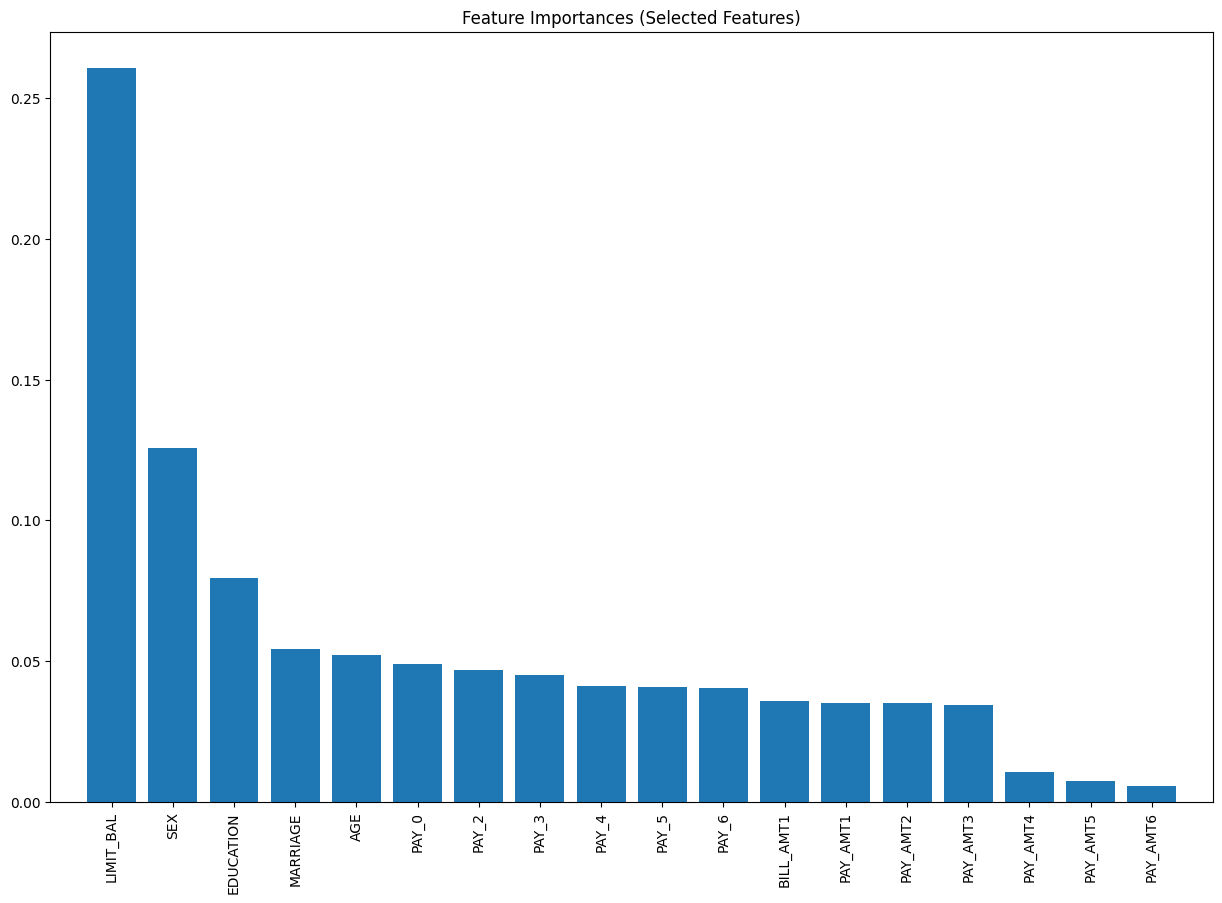

Feature ranking (selected features):
1. Feature LIMIT_BAL (0.26064490437054455)
2. Feature SEX (0.12566575658481474)
3. Feature EDUCATION (0.07959085468436375)
4. Feature MARRIAGE (0.054420192073512945)
5. Feature AGE (0.05209494734602149)
6. Feature PAY_0 (0.04885034019006706)
7. Feature PAY_2 (0.046919617937811145)
8. Feature PAY_3 (0.04510199195913632)
9. Feature PAY_4 (0.04130170098647318)
10. Feature PAY_5 (0.040836356672163954)
11. Feature PAY_6 (0.04041939318442347)
12. Feature BILL_AMT1 (0.035820223556057705)
13. Feature PAY_AMT1 (0.03526651392158533)
14. Feature PAY_AMT2 (0.035059978641635806)
15. Feature PAY_AMT3 (0.03450579913980614)
16. Feature PAY_AMT4 (0.010712285008891485)
17. Feature PAY_AMT5 (0.0073546851519714195)
18. Feature PAY_AMT6 (0.005434458590719527)


In [126]:
# Feature importance for the model with selected features
importances_sel = random_forest_lasso.feature_importances_
indices_sel = np.argsort(importances_sel)[::-1]
feature_names_sel = np.array(X_selected.columns)
indices_sel = indices_sel[:len(feature_names_sel)]

sorted_importances_sel = importances_sel[indices_sel[:len(feature_names_sel)]]
sorted_feature_names_sel = feature_names_sel[:len(indices_sel)]

# Plot the feature importances
plt.figure(figsize=(15, 10))
plt.title("Feature Importances (Selected Features)")
plt.bar(range(len(sorted_importances_sel)), sorted_importances_sel, align="center")
plt.xticks(range(len(sorted_importances_sel)), sorted_feature_names_sel, rotation=90)
plt.xlim([-1, len(sorted_importances_sel)])
plt.show()

# Print the feature ranking
print("Feature ranking (selected features):")
for f in range(len(sorted_feature_names_sel)):
    print(f"{f + 1}. Feature {sorted_feature_names_sel[f]} ({sorted_importances_sel[f]})")

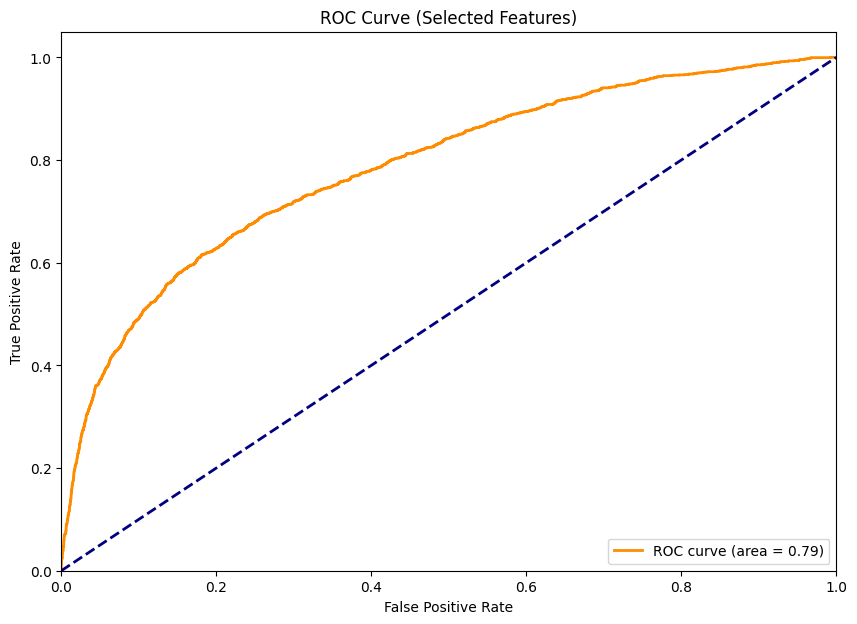

In [129]:
# ROC curve
fpr_sel, tpr_sel, _ = roc_curve(y_test_sel, random_forest_lasso.predict_proba(X_test_sel)[:, 1])
roc_auc_sel = auc(fpr_sel, tpr_sel)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_sel, tpr_sel, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_sel:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Selected Features)')
plt.legend(loc="lower right")
plt.show()

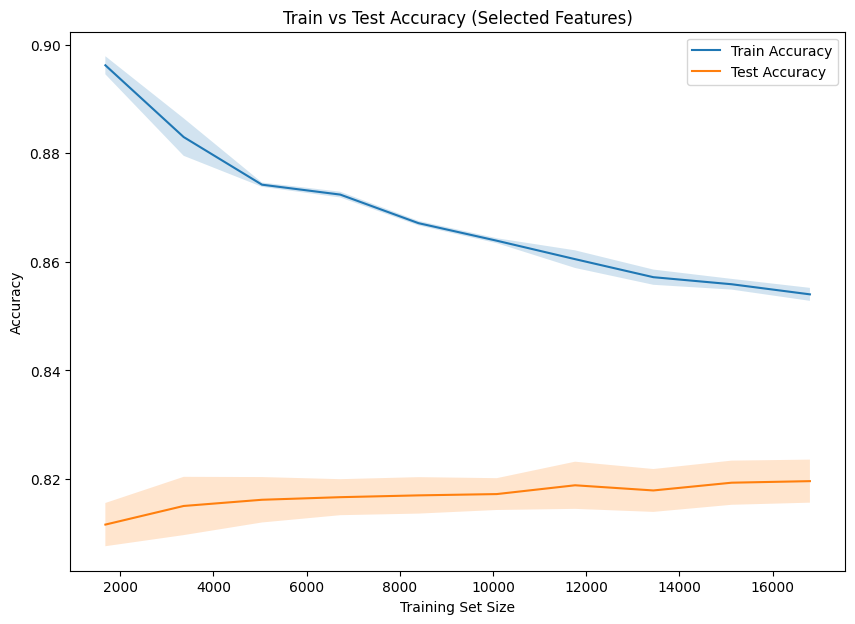

In [133]:
# Train vs Test Accuracy for Random Forest with Selected Features
train_sizes, train_scores, test_scores = learning_curve(random_forest_lasso, X_train_sel, y_train_sel, train_sizes=train_sizes, cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Train Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Test Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy (Selected Features)')
plt.legend()
plt.show()

---

## Model Interpretability

### All Features

In [106]:
# Initialize the SHAP explainer for the best model with all features
explainer_all = shap.TreeExplainer(random_forest_all_features)
shap_values_all = explainer_all.shap_values(X_test)

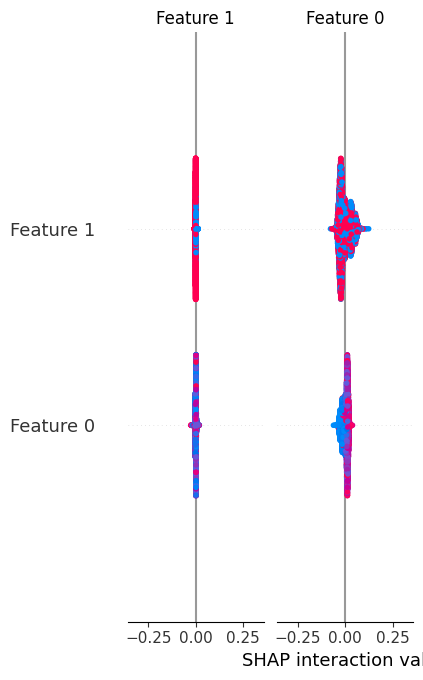

In [107]:
# Summary plot for the model with all features
shap.summary_plot(shap_values_all, X_test, plot_type="bar")

### Lasso Features

In [103]:
# Initialize the SHAP explainer for the best model with selected features
explainer_sel = shap.TreeExplainer(random_forest_lasso)
shap_values_sel = explainer_sel.shap_values(X_test_sel)

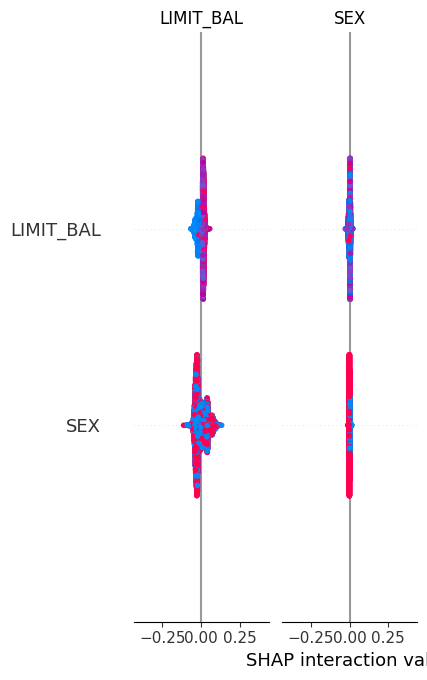

In [104]:
shap.summary_plot(shap_values_sel, X_test_sel, plot_type="bar")